In [1]:
import tensorflow as tf

# Tensorflow 

tensorflow에서 이번에 alpha 버전을 출시해서 경험삼아 사용해 보기로 하였다. `tensorflow-alpha`는 keras의 기능을 더 잘살려서 사용하기 편해졌고 최대한 `tensorflow-alpha`의 기능을 잘살려볼 것이다.

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
import os
import time 
import matplotlib.pyplot as plt
import numpy as np
import cv2

# dataset download
        
`tf.keras.util.get_file(fname,origin,extract)` 안에 매개변수가 더 있지만 내가 사용하는 것만 적었다.

- `fname` : 파일 이름
- `origin` : 파일의 URL
- `extrack` : tar또는 zip과 같이 Archive로서 파일을 추출한다.

In [4]:
map_dataset_url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz'
map_dataset_path = tf.keras.utils.get_file('map.tar.gz',
                                      origin=map_dataset_url,
                                      extract=True)

In [5]:
PATH = os.path.join(os.path.dirname(map_dataset_path), r'maps/')
print(PATH)

C:\Users\woals\.keras\datasets\maps/


# image read

## opencv

이미지 처리 분야에서 많이 쓰이지만 이미지가 BGR순서로 저장되기 때문에 사용하는데 제약이 있다.

## matplotlib

RGB로 읽어주는 maplot을 사용할 것이다.

In [6]:
# 이미지의 이름을 저장
images = os.listdir(PATH)

(600, 1200, 3)


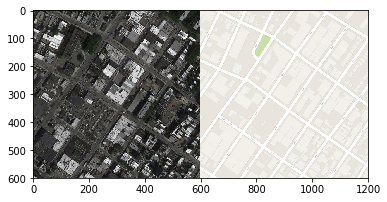

In [7]:
# 이미지 하나를 꺼내서 읽는다
plt_image = plt.imread(PATH+'train/10.jpg')
plt.imshow(plt_image)
print(plt_image.shape)

# preprocessing

- 이미지의 가로를 기준으로 2등분해서 이미지를 나누어 준다.
- 실제 지도 이미지가 `input`이 될 것이다.
- 그림 지도 이미지가 `target`이 될 것이다.
- 실제 지도 -> 그림 지도

In [8]:
def split_image(img):
    tmp = np.split(img,2,axis=1)
    img_A = tmp[0]
    img_B = tmp[1]

    return img_A,img_B

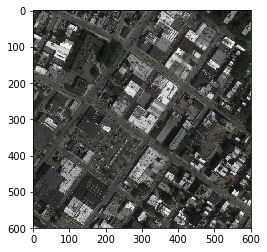

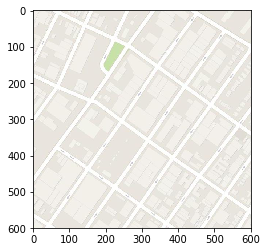

In [19]:
input_, target_ = split_image(plt_image)

input_ = tf.cast(input_, tf.float32)
target_ = tf.cast(target_,tf.float32)

plt.figure()
plt.imshow(input_/255.0)
plt.figure()
plt.imshow(target_/255.0)

## input normalization
- input 이미지의 pixel값을 -1 ~ 1로 정규화 시켜서 학습을 더 잘되게 한다. 값이 퍼지는 것을 모아주고 시작한다고 이해하면 쉬울거 같다.

In [10]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

## resize

In [ ]:
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    target_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, target_image

## crop

In [ ]:
def random_crop(input_image, target_image):
    stacked_image = tf.stack([input_image, target_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

## jitter

In [ ]:
@tf.function()
def random_jitter(input_image, target_image):
    input_image, target_image = resize(input_image, target_image, 286, 286)

    input_image, target_image = random_crop(input_image, target_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image

## train data

## test data

# Model

이미지 출처 : [https://affinelayer.com/pix2pix/](https://affinelayer.com/pix2pix/)

## Generator



![generate](./generate.PNG)



생성자는 실제 지도 이미지를 입력 받았을 때 그림 지도 이미지를 생성해주는 생성자입니다. `encoder-decoder` 구조를 가지는 모델 입니다.

## Discriminator



![discriminator](./discriminator.PNG)




구별자는 그림 지도 이미지와 `Generator`가 만들어낸 그림 지도 이미지중에 뭐가 진짜인지 찾아내는 모델 입니다.

---

생성자는 학습을 거듭할 때 마다 진짜 그림 이미지 같이 만들고 싶어하고 구별자는 누가 가짜인지 진짜인지 잘 구분해 하고 싶기 때문에 둘이 적대적인 관계를 유지합니다. 이것이 GAN을 적대적 생성 모델이라고 부르는 이유 입니다.

In [11]:
def encoder(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [13]:
down_model = encoder(3, 4)
down_result = down_model(tf.expand_dims(input_, 0))
print (down_result.shape)

(1, 300, 300, 3)
